In [2]:
from typing import Tuple
import gymnasium as gym
from src.policies.epsilon_greedy import EpsilonGreedy
import torch
import torch.nn as nn

import numpy as np
from matplotlib import pyplot as plt



In [3]:
class Qnet(nn.Module):
    def __init__(
            self,
            in_shape: Tuple[int],
            nbr_actions: int,
        ):
        super().__init__()
        self.fc = nn.Linear(in_features=int(np.prod(in_shape)), out_features=int(nbr_actions), bias=False)


    def forward(self, x):
        return self.fc(x)
    

In [15]:
torch.manual_seed(0)

batch_size = 10000

env = gym.make("LunarLander-v2")
qnet = Qnet(in_shape=env.observation_space.shape, nbr_actions=env.action_space.n)

batch = torch.randn(batch_size,  *env.observation_space.shape)

with torch.no_grad():
    Q_ref = qnet(batch)

greedy_actions = Q_ref.argmax(dim=1).numpy()


policy = EpsilonGreedy(
    action_space=env.action_space,
    observation_space=env.observation_space,
    Qnet=qnet,
    eps_min=0.0,
    eps_max=1.0,
    eps_decay=0.99,
)


num_episodes = 500
    
stat = {"eps": [], "eps_est": [], "eps_ref":[], "p_greedy":[]}
    
for episode in range(num_episodes):

    actions = policy(batch.numpy())
    rate = sum(actions==greedy_actions)/batch_size

    stat["eps"].append(policy.epsilon)
    stat["eps_est"].append((1-rate)*float(env.action_space.n/(env.action_space.n-1)))
    stat["eps_ref"].append(np.clip(policy.eps_max*policy.eps_decay**episode, policy.eps_min, policy.eps_max))
    stat["p_greedy"].append(rate)

    policy.decay()
    

    





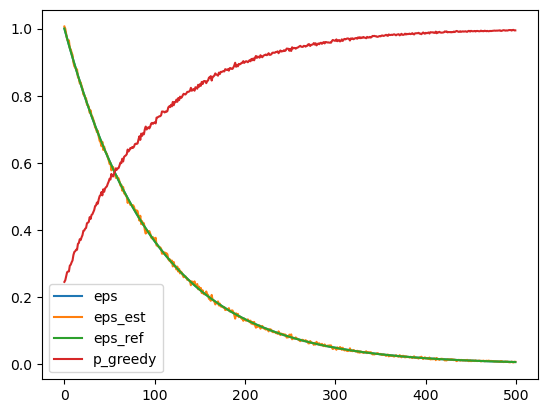

In [16]:
for key, value in stat.items():
    plt.plot(np.arange(num_episodes), value, label=key)

plt.legend()